#### This module test how training channel influence the PSNR

Use net structure: ESPCN
Hyper parameters:
- Learning rate decay: 0.9 for each iteration
- start learning rate: 0.01
- second part learning rate = learning rate * 0.1
- criterion: MSELoss
- optimizer: Adam
- patch size = 64
- batch size = 64

In [93]:
import os
import torch
import data_loader
from criteria import PSNR, SSIM, show_img_in_loader_and_comparison, test_psnr_ssim_interpolation
from plot import show_img
import numpy as np
from ESPCN_model import ESPCN
import ESPCN_model
import matplotlib.pyplot as plt
import cv2
import torch.nn as nn
from tqdm import tqdm
import math

In [2]:
base_path = r"D:\programming\dataset\DIV2K"
valid_hr = os.path.join(base_path, "DIV2K_valid_HR")
valid_lr = os.path.join(base_path, "DIV2K_valid_LR_bicubic_X2")

test PSNR for interpolation BGR channel

In [57]:

def PSNR_interpolation():
    h5_train_path = os.path.join(base_path, "train_BGR_channel")
    train_dataloader, val_dataloader = data_loader.create_train_val_data_loader(
        h5_train_path, valid_hr, valid_lr, batch_size=1)
    psnr_list = list()
    ssim_list = list()
    with tqdm(total=250) as t:
        for hr, lr in val_dataloader:
            hr = (np.squeeze(hr.numpy()) * 255).astype(np.uint8)
            hr = cv2.cvtColor(hr, cv2.COLOR_YCR_CB2BGR)
            hr = hr.astype(np.float32)

            lr = (np.squeeze(lr.numpy()) * 255).astype(np.uint8)
            lr = cv2.cvtColor(lr, cv2.COLOR_YCR_CB2BGR)
            lr = cv2.resize(lr, (hr.shape[1], hr.shape[0]), interpolation=cv2.INTER_CUBIC)
            lr = lr.astype(np.float32)
            
            psnr = PSNR(hr, lr, 255)
            psnr_list.append(psnr)
            ssim = SSIM(hr, lr)
            ssim_list.append(ssim)
            t.update(1)

    print("PSNR interpolation is: {:.3f}, SSIM interpolation is: {:.3f}".
          format(np.average(psnr_list), np.average(ssim_list)))
    
PSNR_interpolation()

100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [04:56<00:00,  1.18s/it]

PSNR interpolation is: 31.261, SSIM interpolation is: 0.898


#### rewrite model

In [50]:
def get_ESPCN_model(model_save_path=None, channel=1):
    """
    load SRCNN model, if no model_save_path, then init a new model
    """
    model = ESPCN(2, channel)
    if (model_save_path == None) or (not os.path.exists(model_save_path)):
        print("init new model parameter")
        model.init_weights()
        current_epoch = 0
        PSNR_list = list()
    else:
        para = torch.load(model_save_path)
        model.load_state_dict(para["state_dict"])
        current_epoch = para["epoch"]
        PSNR_list = para["psnr"]
        print("load model parameter")
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    print("use device: ", device)
    return model, device, current_epoch, PSNR_list


def test_psnr_ssim(model, device, val_dataloader):
    """
    test PSNR and SSIM for each epoch
    """
    psnr_list = list()
    for hr, lr in val_dataloader:
        hr = (np.squeeze(hr.numpy()) * 255).astype(np.uint8)
        hr = cv2.cvtColor(hr, cv2.COLOR_YCR_CB2BGR)
        hr = hr.astype(np.float32)
        
        lr = (np.squeeze(lr.numpy()) * 255).astype(np.uint8)
        lr = cv2.cvtColor(lr, cv2.COLOR_YCR_CB2BGR)
        lr = lr.astype(np.float32)
        lr = lr / 255
        lr = np.transpose(lr, [2,0,1])
        lr = np.expand_dims(lr, 0)
        
        lr = torch.tensor(lr)
        lr = lr.to(device)
        lr = model(lr)
        lr = lr.cpu().data.numpy()  # get the model result
        
        lr[lr > 1] = 1  # cut Y channel, 16<=Y<=235
        lr[lr < 0] = 0
        lr = np.squeeze(lr)
        lr = np.transpose(lr, [1,2,0])
        lr = lr * 255
        psnr = PSNR(lr, hr, 255)  # test the result for RSCNN
        psnr_list.append(psnr)
    return np.average(psnr_list)


def ESPCN_train(model, device, train_dataloader, val_dataloader,
                current_epoch, PSNR_list, model_save_path,
                max_epoch=10):
    lr_begin = 0.01
    criterion = nn.MSELoss()

    with tqdm(total=len(train_dataloader) * max_epoch) as t:
        t.update(len(train_dataloader) * current_epoch)  # update to current state
        while current_epoch < max_epoch:
            lr = math.pow(0.90, current_epoch) * lr_begin
            optimizer = torch.optim.Adam([
                {'params': model.first_part.parameters()},
                {'params': model.last_part.parameters(), 'lr': lr * 0.1}
            ], lr=lr)

            for hr, lr in train_dataloader:
                hr, lr = hr.to(device), lr.to(device)
                lr_after = model(lr)
                loss = criterion(lr_after, hr)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                t.update(1)
            # test result
            current_epoch += 1
            psnr = test_psnr_ssim(model, device, val_dataloader)
            PSNR_list.append(psnr)
            torch.save({"epoch": current_epoch, "state_dict": model.state_dict(),
                        "psnr": PSNR_list}, model_save_path)

#### train BGR channel together

In [63]:
def train_BGR(h5_train_path, model_save_path, batch_size):
    h5_train_path = os.path.join(base_path, h5_train_path)
    model_save_path = os.path.join(base_path, model_save_path)

    train_dataloader, val_dataloader = data_loader.create_train_val_data_loader(
        h5_train_path, valid_hr, valid_lr, batch_size=batch_size)
    model, device, current_epoch, PSNR_list = \
        get_ESPCN_model(model_save_path=model_save_path, channel=3)

    ESPCN_train(model, device, train_dataloader, val_dataloader,
                   current_epoch, PSNR_list, model_save_path,
                   max_epoch=20)
    
train_BGR("train_BGR_channel", "ESPCN_BGR_channel.model", 256)
torch.cuda.empty_cache()

init new model parameter
use device:  cuda:0


100%|████████████████████████████████████████████████████████████████████████████| 7580/7580 [1:05:50<00:00,  1.92it/s]


In [66]:
def get_BGR_learning_curve():
    model_save_path = os.path.join(base_path, "ESPCN_BGR_channel.model")
    model, device, current_epoch, PSNR_list = \
            get_ESPCN_model(model_save_path=model_save_path, channel=3)
    return PSNR_list

BGR_PSNR = get_BGR_learning_curve()

load model parameter
use device:  cuda:0


#### train R, G, B channel separatly

#### redefine data loader

In [95]:
from torch.utils.data import Dataset, DataLoader
import h5py

class RSCNNTrainDataset(Dataset):
    def __init__(self, h5_train_path, channel):
        super(RSCNNTrainDataset, self).__init__()
        self.index = list()
        self.h5_train_path = h5_train_path
        self.channel = channel
        with open(os.path.join(h5_train_path, "index.txt")) as index_file:
            lines = index_file.readlines()
            for line in lines:
                self.index.append(int(line.strip()))

    def __getitem__(self, idx):
        for i in range(len(self.index)):
            if idx < self.index[i]:
                path = os.path.join(self.h5_train_path, str(i) + ".hdf5")
                with h5py.File(path, 'r') as f:
                    hr = f['hr'][idx]
                    lr = f['lr'][idx]
                    hr = hr[self.channel]
                    lr = lr[self.channel]
                    hr = np.expand_dims(hr, 0)
                    lr = np.expand_dims(lr, 0)
                    return hr, lr
            else:
                idx -= self.index[i]

    def __len__(self):
        return np.sum(self.index)
    
def create_channel_train_val_data_loader(h5_train_path, valid_hr, valid_lr, channel, batch_size=1):
    train_dataset = RSCNNTrainDataset(h5_train_path, channel)
    ValDataset_ = data_loader.ValDataset(0, valid_hr, valid_lr)
    train_dataloader = DataLoader(dataset=train_dataset,
                                  batch_size=batch_size,
                                  shuffle=True,
                                  drop_last=True)
    val_dataloader = DataLoader(dataset=ValDataset_,
                                batch_size=1)
    return train_dataloader, val_dataloader


#### rewrite train model

In [118]:
def test_psnr_ssim(model, device, val_dataloader, test_channel):
    """
    test PSNR and SSIM for each epoch
    """
    psnr_list = list()
    for hr, lr in val_dataloader:
        hr = (np.squeeze(hr.numpy()) * 255).astype(np.uint8)
        hr = cv2.cvtColor(hr, cv2.COLOR_YCR_CB2BGR)
        hr = hr.astype(np.float32)
        hr = hr[:,:,test_channel]
        
        lr = (np.squeeze(lr.numpy()) * 255).astype(np.uint8)
        lr = cv2.cvtColor(lr, cv2.COLOR_YCR_CB2BGR)
        lr = lr[:,:,test_channel]
        lr = lr.astype(np.float32)
        lr = lr / 255
        lr = np.expand_dims(lr, [0,1])

        lr = torch.tensor(lr)
        lr = lr.to(device)
        lr = model(lr)
        lr = lr.cpu().data.numpy()  # get the model result
        
        lr[lr > 1] = 1  
        lr[lr < 0] = 0
        lr = np.squeeze(lr)
        lr = lr * 255
        psnr = PSNR(lr, hr, 255)  # test the result for RSCNN
        psnr_list.append(psnr)
    return np.average(psnr_list)


def ESPCN_train(model, device, train_dataloader, val_dataloader,
                current_epoch, PSNR_list, model_save_path, test_channel,
                max_epoch=10):
    lr_begin = 0.01
    criterion = nn.MSELoss()

    with tqdm(total=len(train_dataloader) * max_epoch) as t:
        t.update(len(train_dataloader) * current_epoch)  # update to current state
        while current_epoch < max_epoch:
            lr = math.pow(0.90, current_epoch) * lr_begin
            optimizer = torch.optim.Adam([
                {'params': model.first_part.parameters()},
                {'params': model.last_part.parameters(), 'lr': lr * 0.1}
            ], lr=lr)

            for hr, lr in train_dataloader:
                hr, lr = hr.to(device), lr.to(device)
                lr_after = model(lr)
                loss = criterion(lr_after, hr)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                t.update(1)
            # test result
            current_epoch += 1
            psnr = test_psnr_ssim(model, device, val_dataloader, test_channel)
            PSNR_list.append(psnr)
            torch.save({"epoch": current_epoch, "state_dict": model.state_dict(),
                        "psnr": PSNR_list}, model_save_path)

#### train BGR separatly

In [121]:
def train_channel(h5_train_path, model_save_path, batch_size, channel):
    h5_train_path = os.path.join(base_path, h5_train_path)
    model_save_path = os.path.join(base_path, model_save_path)

    train_dataloader, val_dataloader = create_channel_train_val_data_loader(
        h5_train_path, valid_hr, valid_lr, channel=channel, batch_size=batch_size)
    model, device, current_epoch, PSNR_list = \
        get_ESPCN_model(model_save_path=model_save_path)

    ESPCN_train(model, device, train_dataloader, val_dataloader,
                   current_epoch, PSNR_list, model_save_path, channel,
                   max_epoch=20)
    
train_channel("train_BGR_channel", "ESPCN_B_channel.model", 256, 0)
torch.cuda.empty_cache()
train_channel("train_BGR_channel", "ESPCN_G_channel.model", 256, 1)
torch.cuda.empty_cache()
train_channel("train_BGR_channel", "ESPCN_R_channel.model", 256, 2)
torch.cuda.empty_cache()

load model parameter
use device:  cuda:0


100%|██████████████████████████████████████████████████████████████████████████████| 7580/7580 [56:15<00:00,  2.25it/s]


init new model parameter
use device:  cuda:0


100%|████████████████████████████████████████████████████████████████████████████| 7580/7580 [1:01:42<00:00,  2.05it/s]


init new model parameter
use device:  cuda:0


100%|████████████████████████████████████████████████████████████████████████████| 7580/7580 [1:05:48<00:00,  1.92it/s]


In [131]:
def get_B_G_R_learning_curve():
    model_name = {
        "B_channel":"ESPCN_B_channel.model",
        "G_channel":"ESPCN_G_channel.model",
        "R_channel":"ESPCN_R_channel.model",
    }
    PSNR_result = dict()
    for channel, model_path in model_name.items():
        model, device, current_epoch, PSNR_list = \
            get_ESPCN_model(model_save_path=os.path.join(base_path, model_path))
        PSNR_result[channel] = PSNR_list
    return PSNR_result

B_G_R_PSNR = get_B_G_R_learning_curve()

load model parameter
use device:  cuda:0
load model parameter
use device:  cuda:0
load model parameter
use device:  cuda:0


#### make comparison

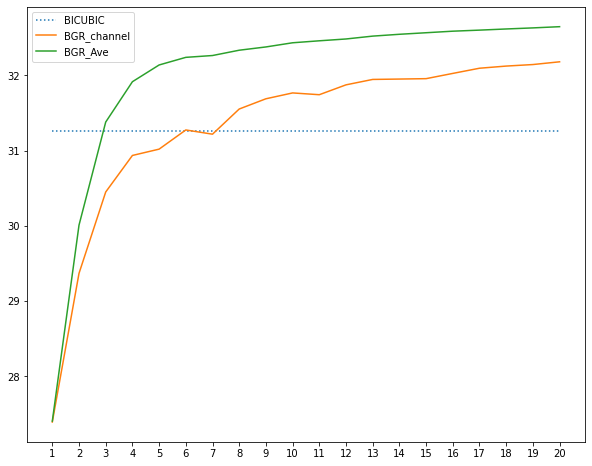

In [140]:
def plot(BGR_PSNR, B_G_R_PSNR):
    plt.figure(figsize=(10,8))
    plt.xticks(np.linspace(1,20,20))
    plt.yticks(np.linspace(25,35,11))
    plt.plot(range(1,21), np.ones(shape=(20,))*31.261, ':', label="BICUBIC")
    
    average_bgr = np.zeros(shape=(20,))
    plt.plot(range(1,21), BGR_PSNR, label="BGR_channel")
    for model_name, psnr in B_G_R_PSNR.items():
        # plt.plot(range(1,21), psnr, label=model_name)
        average_bgr += np.asarray(psnr)
    average_bgr /= 3
    plt.plot(range(1,21), average_bgr, label="BGR_Ave")
    plt.legend()
    plt.show()
        
plot(BGR_PSNR, B_G_R_PSNR)

#### test train on Y channel and use it to calculate PSNR in Y and BGR channel

In [223]:
def test_psnr_ssim(model, device, val_dataloader):
    """
    test PSNR and SSIM for each epoch
    """
    Y_psnr_list = list()
    BGR_psnr_list = list()
    for hr, lr in val_dataloader:
        # get the hr image, and hr_y channel
        hr = hr.numpy() * 255  # read hr from data loader
        hr = np.reshape(hr, (hr.shape[1], hr.shape[2], hr.shape[3]))  # change shape to a image
        hr_y = hr[:, :, 0]  # get Y channel of hr
        hr = np.array(hr).astype(np.uint8)  # change to uint8
        hr = cv2.cvtColor(hr, cv2.COLOR_YCR_CB2BGR)  # change back to BGR

        # change lr to numpy at first, and interpolation to get the high resolution CbCr
        lr_np = lr.numpy() * 255  # read lr from data loader
        lr_np = np.squeeze(lr_np)  # change shape to a image
        lr_np = lr_np.astype(np.uint8)  # change to uint8
        lr_np = cv2.cvtColor(lr_np, cv2.COLOR_YCR_CB2BGR)  # convert to RGB first
        lr_np = cv2.resize(lr_np, (hr.shape[1], hr.shape[0]), interpolation=cv2.INTER_CUBIC)  # interpolation
        lr_img = lr_np
        lr_np = cv2.cvtColor(lr_np, cv2.COLOR_BGR2YCR_CB)  # convert to YCbCr again
        lr_y = lr_np[:, :, 0]
        lr_Cr = lr_np[:, :, 1]
        lr_Cr = np.expand_dims(lr_Cr, axis=(0))
        lr_Cb = lr_np[:, :, 2]
        lr_Cb = np.expand_dims(lr_Cb, axis=(0))

        # Y channel will be got from model
        lr_y_after = lr[:, :, :, 0]  # get Y channel
        lr_y_after = torch.reshape(lr_y_after, (1, 1, lr.shape[1], lr.shape[2]))
        lr_y_after = lr_y_after.to(device)  # put into model
        lr_y_after = model(lr_y_after)
        lr_y_after = lr_y_after.cpu().data.numpy()  # get the model result
        lr_y_after = np.reshape(lr_y_after, newshape=(1, lr_y_after.shape[2], lr_y_after.shape[3]))
        lr_y_after[lr_y_after > 1] = 1  # cut Y channel, 16<=Y<=235
        lr_y_after[lr_y_after < 0] = 0
        lr_y_after = lr_y_after * 255

        # combine together
        lr_after = np.concatenate([lr_y_after, lr_Cr, lr_Cb], axis=0)  # conbine the three channel together
        lr_after = np.transpose(lr_after, (1, 2, 0))  # to normal range
        lr_after = lr_after.astype(np.uint8)  # convert to uint8 type
        lr_after = cv2.cvtColor(lr_after, cv2.COLOR_YCR_CB2BGR)  # change back to BGR

        # demonstrate
        lr_y_after = np.squeeze(lr_y_after)

        hr = hr.astype(np.float32)
        lr_after = lr_after.astype(np.float32)
        
        Y_psnr = PSNR(hr_y, lr_y_after, 255)  # test the Y channel result for ESPCN
        BGR_psnr = PSNR(hr, lr_after, 255) # test the BGR channel result for ESPCN
        Y_psnr_list.append(Y_psnr)
        BGR_psnr_list.append(BGR_psnr)
                
    return np.average(Y_psnr_list), np.average(BGR_psnr_list)


def ESPCN_train(model, device, train_dataloader, val_dataloader,
                current_epoch, Y_PSNR_list, BGR_PSNR_list, model_save_path,
                max_epoch=10):
    lr_begin = 0.01
    criterion = nn.MSELoss()

    with tqdm(total=len(train_dataloader) * max_epoch) as t:
        t.update(len(train_dataloader) * current_epoch)  # update to current state
        while current_epoch < max_epoch:
            lr = math.pow(0.90, current_epoch) * lr_begin
            optimizer = torch.optim.Adam([
                {'params': model.first_part.parameters()},
                {'params': model.last_part.parameters(), 'lr': lr * 0.1}
            ], lr=lr)

            for hr, lr in train_dataloader:
                hr, lr = hr.to(device), lr.to(device)
                lr_after = model(lr)
                loss = criterion(lr_after, hr)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                t.update(1)
            # test result
            current_epoch += 1
            Y_psnr, BGR_psnr = test_psnr_ssim(model, device, val_dataloader)
            Y_PSNR_list.append(Y_psnr)
            BGR_PSNR_list.append(BGR_psnr)
            torch.save({"epoch": current_epoch, "state_dict": model.state_dict(),
                        "Y_psnr": Y_PSNR_list, "BGR_psnr": BGR_PSNR_list}, model_save_path)


def get_ESPCN_model(model_save_path=None, channel=1):
    """
    load SRCNN model, if no model_save_path, then init a new model
    """
    model = ESPCN(2, channel)
    if (model_save_path == None) or (not os.path.exists(model_save_path)):
        print("init new model parameter")
        model.init_weights()
        current_epoch = 0
        Y_PSNR_list = list()
        BGR_PSNR_list = list()
    else:
        para = torch.load(model_save_path)
        model.load_state_dict(para["state_dict"])
        current_epoch = para["epoch"]
        Y_PSNR_list = para["Y_psnr"]
        BGR_PSNR_list = para["BGR_psnr"]
        print("load model parameter")
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    print("use device: ", device)
    return model, device, current_epoch, Y_PSNR_list, BGR_PSNR_list


def script(h5_train_path, model_save_path, batch_size):
    h5_train_path = os.path.join(base_path, h5_train_path)
    model_save_path = os.path.join(base_path, model_save_path)

    train_dataloader, val_dataloader = data_loader.create_train_val_data_loader(
        h5_train_path, valid_hr, valid_lr, batch_size=batch_size)
    model, device, current_epoch, Y_PSNR_list, BGR_PSNR_list = \
            get_ESPCN_model(model_save_path=model_save_path)

    ESPCN_train(model, device, train_dataloader, val_dataloader,
                   current_epoch, Y_PSNR_list, BGR_PSNR_list, model_save_path,
                   max_epoch=20)
    
script("train_Ychannel_size_64_128", "ESPCN_patch64_128_Ychannel_compare_BGR.model", 256)
torch.cuda.empty_cache()

load model parameter
use device:  cuda:0


100%|██████████████████████████████████████████████████████████████████████████████| 7580/7580 [35:07<00:00,  3.60it/s]


In [225]:
model, device, current_epoch, Y_PSNR_list, BGR_PSNR_list = \
            get_ESPCN_model(model_save_path=os.path.join(base_path, "ESPCN_patch64_128_Ychannel_compare_BGR.model"))

load model parameter
use device:  cuda:0


#### final comparison

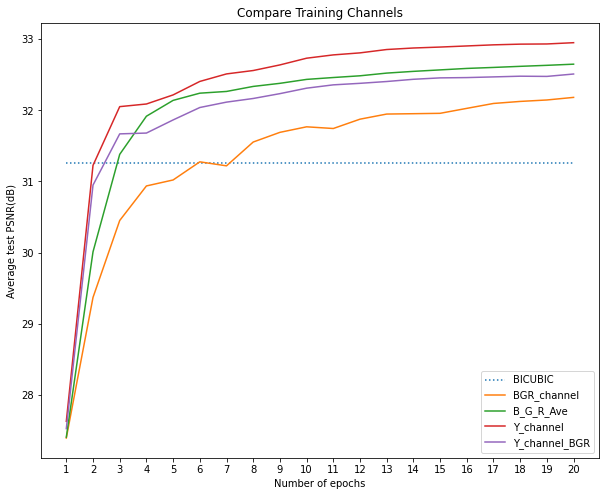

In [229]:
def plot_all(train_BGR_PSNR, train_B_G_R_PSNR, train_Y_PSNR, train_Y_BGR_PSNR_list):
    plt.figure(figsize=(10,8))
    plt.xticks(np.linspace(1,20,20))
    plt.yticks(np.linspace(25,35,11))
    plt.title("Compare Training Channels")
    plt.ylabel("Average test PSNR(dB)")
    plt.xlabel("Number of epochs")
    plt.plot(range(1,21), np.ones(shape=(20,))*31.261, ':', label="BICUBIC")
    
    average_bgr = np.zeros(shape=(20,))
    plt.plot(range(1,21), BGR_PSNR, label="BGR_channel")
    for model_name, psnr in B_G_R_PSNR.items():
        # plt.plot(range(1,21), psnr, label=model_name)
        average_bgr += np.asarray(psnr)
    average_bgr /= 3
    plt.plot(range(1,21), average_bgr, label="B_G_R_Ave")
    plt.plot(range(1,21), train_Y_PSNR, label="Y_channel")
    plt.plot(range(1,21), train_Y_BGR_PSNR_list, label="Y_channel_BGR")
    plt.legend()
    plt.show()
        
plot_all(BGR_PSNR, B_G_R_PSNR, Y_PSNR_list, BGR_PSNR_list)

#### test on a image

- original
- interpolation
- BGR channel model
- B_G_R channel model
- Y channel model 

In [334]:
def Y_channel(base_path, HR_path, LR_path, Y_model_path):
    model = ESPCN_model.ESPCN(2)
    para = torch.load(Y_model_path)
    model.load_state_dict(para["state_dict"])
    model.to(device)
    
    hr = cv2.imread(HR_path)
    hr = hr.astype(np.float32)
    
    lr = cv2.imread(LR_path)
    lr_np = cv2.resize(lr, (hr.shape[1], hr.shape[0]), interpolation=cv2.INTER_CUBIC)  # interpolation
    lr_np = cv2.cvtColor(lr_np, cv2.COLOR_BGR2YCR_CB)  # convert to YCbCr
    lr_Cr = lr_np[:, :, 1]
    lr_Cr = np.expand_dims(lr_Cr, axis=(0))
    lr_Cb = lr_np[:, :, 2]
    lr_Cb = np.expand_dims(lr_Cb, axis=(0))
    # change lr to numpy at first, and interpolation to get the high resolution CbCr
    
    lr = cv2.cvtColor(lr, cv2.COLOR_BGR2YCR_CB)  # convert to YCbCr again
    lr_y = lr[:, :, 0].astype(np.float32) / 255
    lr_y = np.expand_dims(lr_y, [0,1])
    
    lr_y = torch.tensor(lr_y)
    lr_y = lr_y.to(device)  # put into model
    lr_y = model(lr_y)
    lr_y = lr_y.cpu().data.numpy()  # get the model result

    lr_y = np.reshape(lr_y, newshape=(1, lr_y.shape[2], lr_y.shape[3]))
    lr_y[lr_y > 1] = 1  # cut Y channel, 16<=Y<=235
    lr_y[lr_y < 0] = 0
    lr_y = lr_y * 255
    lr_y = lr_y.astype(np.uint8)

    # combine together
    lr = np.concatenate([lr_y, lr_Cr, lr_Cb], axis=0)  # conbine the three channel together
    lr = np.transpose(lr, (1, 2, 0))  # to normal range
    lr = lr.astype(np.uint8)  # convert to uint8 type
    lr = cv2.cvtColor(lr, cv2.COLOR_YCR_CB2BGR)  # change back to BGR
    
    cv2.imwrite(os.path.join(base_path, "Y_channel.png"), lr)
    lr = lr.astype(np.float32)
    print("PSNR for Y channel: {:.3f}".format(PSNR(hr, lr, 255)))
    torch.cuda.empty_cache()
    

def BGR_channel(base_path, HR_path, LR_path, BGR_model_path):
    model = ESPCN_model.ESPCN(2, num_channels=3)
    para = torch.load(BGR_model_path)
    model.load_state_dict(para["state_dict"])
    model.to(device)
    
    hr = cv2.imread(HR_path)
    hr = hr.astype(np.float32)
    
    lr = cv2.imread(LR_path)
    lr = lr.astype(np.float32) / 255
    lr = np.transpose(lr, [2,0,1])
    lr = np.expand_dims(lr,0)
    lr = torch.tensor(lr)
    lr = lr.to(device)
    lr = model(lr)
    lr = lr.cpu().data.numpy()  # get the model result
    lr[lr > 1] = 1
    lr[lr < 0] = 0
    lr = np.squeeze(lr)
    lr = np.transpose(lr, [1,2,0])
    lr = lr * 255
    lr = lr.astype(np.uint8)
    cv2.imwrite(os.path.join(base_path, "BGR_channel.png"), lr)
    lr = lr.astype(np.float32)
    print("PSNR for BGR channel: {:.3f}".format(PSNR(hr, lr, 255)))
    torch.cuda.empty_cache()
    
    
def B_G_R_channel(base_path, HR_path, LR_path, B_model_path, G_model_path, R_model_path):
    hr = cv2.imread(HR_path)
    hr = hr.astype(np.float32)
    lr = cv2.imread(LR_path)
    lr = lr.astype(np.float32) / 255
    lr_B = np.expand_dims(lr[:, :, 0], [0,1])
    lr_B = torch.tensor(lr_B)
    lr_G = np.expand_dims(lr[:, :, 1], [0,1])
    lr_G = torch.tensor(lr_G)
    lr_R = np.expand_dims(lr[:, :, 2], [0,1])
    lr_R = torch.tensor(lr_R)
    
    # B channel
    model_B = ESPCN_model.ESPCN(2)
    para = torch.load(B_model_path)
    model_B.load_state_dict(para["state_dict"])
    model_B.to(device)
    
    lr_B = lr_B.to(device)
    lr_B = model_B(lr_B)
    lr_B = lr_B.cpu().data.numpy()  # get the model result
    lr_B[lr_B > 1] = 1
    lr_B[lr_B < 0] = 0
    lr_B = lr_B * 255
    lr_B = np.reshape(lr_B, newshape=(1, lr_B.shape[2], lr_B.shape[3]))
    torch.cuda.empty_cache()
    
    # G channel
    model_G = ESPCN_model.ESPCN(2)
    para = torch.load(G_model_path)
    model_G.load_state_dict(para["state_dict"])
    model_G.to(device)
    
    lr_G = lr_G.to(device)
    lr_G = model_G(lr_G)
    lr_G = lr_G.cpu().data.numpy()  # get the model result
    lr_G[lr_G > 1] = 1
    lr_G[lr_G < 0] = 0
    lr_G = lr_G * 255
    lr_G = np.reshape(lr_G, newshape=(1, lr_G.shape[2], lr_G.shape[3]))
    torch.cuda.empty_cache()
    
    # R channel
    model_R = ESPCN_model.ESPCN(2)
    para = torch.load(R_model_path)
    model_R.load_state_dict(para["state_dict"])
    model_R.to(device)
    
    lr_R = lr_R.to(device)
    lr_R = model_G(lr_R)
    lr_R = lr_R.cpu().data.numpy()  # get the model result
    lr_R[lr_R > 1] = 1
    lr_R[lr_R < 0] = 0
    lr_R = lr_R * 255
    lr_R = np.reshape(lr_R, newshape=(1, lr_R.shape[2], lr_R.shape[3]))
    torch.cuda.empty_cache()
    
    lr = np.concatenate([lr_B, lr_G, lr_R], axis=0)  # conbine the three channel together
    lr = np.transpose(lr, (1, 2, 0))  # to normal range
    lr = lr.astype(np.uint8)  # convert to uint8 type
    
    cv2.imwrite(os.path.join(base_path, "B_G_R_channel.png"), lr)
    lr = lr.astype(np.float32)
    print("PSNR for B_G_R channel: {:.3f}".format(PSNR(hr, lr, 255)))
    torch.cuda.empty_cache()
    
    
def test_one_image(base_path, HR_path, LR_path, Y_model_path, B_model_path, 
                   G_model_path, R_model_path, BGR_model_path):
    hr = cv2.imread(HR_path)
    lr = cv2.imread(LR_path)
    Bicubic = cv2.resize(lr, (hr.shape[1], hr.shape[0]))
    cv2.imwrite(os.path.join(base_path, "Bicubic.png"), Bicubic)
    hr = hr.astype(np.float32)
    print("PSNR for Bicubic: {:.3f}".format(PSNR(hr, Bicubic, 255)))
    # Y channel model
    Y_channel(base_path, HR_path, LR_path, Y_model_path)
    # BGR channel model
    BGR_channel(base_path, HR_path, LR_path, BGR_model_path)
    # B G R model
    B_G_R_channel(base_path, HR_path, LR_path, B_model_path, G_model_path, R_model_path)
    

In [335]:
test_one_image(base_path, os.path.join(base_path, "test_HR.png"), os.path.join(base_path, "test_LR.png"),
              os.path.join(base_path, "ESPCN_patch64_128_Ychannel_compare_BGR.model"),
              os.path.join(base_path, "ESPCN_B_channel.model"),
              os.path.join(base_path, "ESPCN_G_channel.model"),
              os.path.join(base_path, "ESPCN_R_channel.model"),
              os.path.join(base_path, "ESPCN_BGR_channel.model"))

PSNR for Bicubic: 33.780
PSNR for Y channel: 36.006
PSNR for BGR channel: 35.580
PSNR for B_G_R channel: 36.048


In [310]:
torch.cuda.empty_cache()